In [20]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data', name='alchemy_full')
n_val = len(dataset) // 8; iteration = 1

val_data = dataset[iteration * n_val : (iteration + 1) * n_val]
train_data = dataset[:iteration * n_val] + dataset[(iteration + 1) * n_val:][:1000]

val_loader = DataLoader(val_data, batch_size=len(val_data), shuffle=False)
train_loader = DataLoader(train_data, batch_size=len(train_data), shuffle=True)

In [23]:
dataset[8]

Data(edge_index=[2, 54], edge_attr=[54, 3], x=[26, 9], y=[1, 1], num_nodes=26)

In [27]:
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

In [3]:
from gnnexplain.nn.gnn import GNN

model = GNN.load_from_checkpoint('./checkpoints/Mutagenicity_ReLU_0b9z4g7v.ckpt')

In [13]:
import numpy as np

labels = []
for graph, y in zip(train_batch.to_data_list(), train_batch.y):
    labels.append(y * np.ones(graph.num_nodes))
labels = np.concatenate(labels, axis=0)
labels.shape

(19549,)

In [28]:
from gnnexplain.model.gtree import _get_values

values = _get_values(train_batch, 5)
values[0].shape

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [5]:
from gnnexplain.model.gtree import Explainer
import optuna

explainer = Explainer(**{f"max_depth_{i}" : 2 for i in range(6)} , **{f"ccp_alpha_{i}" : 0. for i in range(6)})

In [6]:
from cProfile import Profile
from pstats import Stats

profiler = Profile()
profiler.runcall(explainer.fit, train_batch, values)
stats = Stats(profiler)
stats.strip_dirs().sort_stats('cumulative').print_stats(30)

         204931 function calls (203349 primitive calls) in 0.481 seconds

   Ordered by: cumulative time
   List reduced from 595 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.000    0.000    0.481    0.120 base_events.py:1908(_run_once)
      2/1    0.019    0.009    0.476    0.476 gtree.py:86(fit)
      205    0.001    0.000    0.128    0.001 batch.py:173(__getitem__)
       50    0.001    0.000    0.126    0.003 batch.py:135(index_select)
      500    0.001    0.000    0.125    0.000 batch.py:112(get_example)
      500    0.011    0.000    0.121    0.000 separate.py:15(separate)
       50    0.040    0.001    0.096    0.002 gtree.py:198(predict)
       50    0.013    0.000    0.093    0.002 gtree.py:167(fit)
       50    0.000    0.000    0.085    0.002 batch.py:82(from_data_list)
     2000    0.047    0.000    0.077    0.000 separate.py:59(_separate)
       50    0.005    0.000    0.068    0.001 collate.py:37(c

In [7]:
explainer.accuracy(val_batch)

1.0

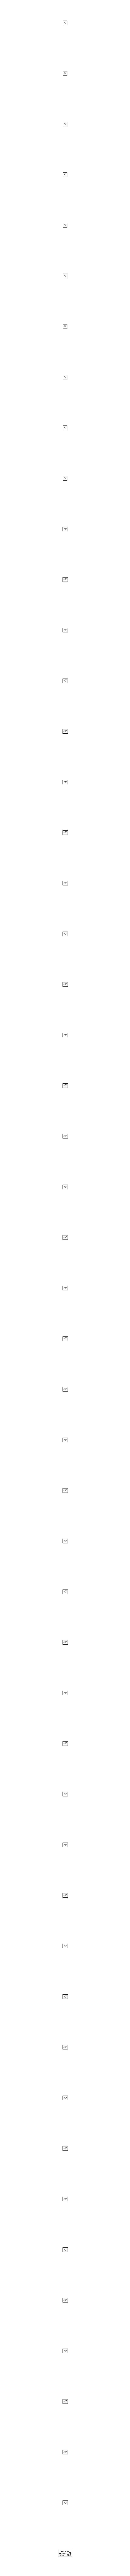

In [8]:
explainer.plot()